In [1]:
import pyspark.sql as ps
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
import pandas
import matplotlib.pyplot as plt
inp_file_path: str = 'file:///D:/MAHE/5thSem/BDA2/data/2019-Oct.csv'

In [2]:
spark: ps.SparkSession = ps.SparkSession.builder.master("yarn").appName("test").getOrCreate()
raw_data: ps.DataFrame = spark.read.csv(inp_file_path, header=True, inferSchema=True)

In [3]:
raw_data.show(5)
raw_data.summary()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 05:30:00|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 05:30:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 05:30:01|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 05:30:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 05:30:04|      view|   1004237|2053013555631882655|electr

DataFrame[summary: string, event_type: string, product_id: string, category_id: string, category_code: string, brand: string, price: string, user_id: string, user_session: string]

In [4]:
str_ind = StringIndexer(inputCols=['event_type', 'category_code'], outputCols=['event_ind', 'category_ind'], handleInvalid='keep')
str_ind = str_ind.fit(raw_data)
eve_dict = {label: ind for ind, label in enumerate(str_ind.labelsArray[0])}
cat_dict = {label: ind for ind, label in enumerate(str_ind.labelsArray[1])}

dataset = str_ind.transform(raw_data)
dataset = dataset.drop(dataset.category_id, dataset.event_type, dataset.category_code). \
    withColumnsRenamed({'event_ind': 'event_type', 'category_ind': 'category_code'}). \
    withColumn('event_time', F.to_date(dataset.event_time))

In [5]:
print(eve_dict)
print(cat_dict)
dataset.show()
print(dataset.summary())

{'view': 0, 'cart': 1, 'purchase': 2}
{'electronics.smartphone': 0, 'electronics.clocks': 1, 'computers.notebook': 2, 'electronics.video.tv': 3, 'electronics.audio.headphone': 4, 'appliances.kitchen.refrigerators': 5, 'appliances.kitchen.washer': 6, 'appliances.environment.vacuum': 7, 'apparel.shoes': 8, 'auto.accessories.player': 9, 'computers.desktop': 10, 'apparel.shoes.keds': 11, 'furniture.bedroom.bed': 12, 'electronics.tablet': 13, 'electronics.audio.subwoofer': 14, 'furniture.living_room.cabinet': 15, 'construction.tools.drill': 16, 'electronics.telephone': 17, 'auto.accessories.videoregister': 18, 'kids.carriage': 19, 'furniture.living_room.sofa': 20, 'appliances.kitchen.blender': 21, 'appliances.kitchen.oven': 22, 'auto.accessories.alarm': 23, 'accessories.bag': 24, 'appliances.kitchen.kettle': 25, 'appliances.kitchen.microwave': 26, 'appliances.iron': 27, 'appliances.kitchen.meat_grinder': 28, 'appliances.environment.air_heater': 29, 'appliances.sewing_machine': 30, 'computer

In [6]:
visits = dataset.groupBy(F.to_date(dataset.event_time).alias("event_time")). \
    agg(F.count_distinct("user_session").alias("number_of_daily_visits"),
        F.count_distinct("user_id").alias("number_of_daily_visitors"))

sales = dataset.where(dataset.event_type == eve_dict['purchase']). \
    withColumn("event_time", F.to_date(dataset.event_time)). \
    groupBy("event_time"). \
    agg(F.count("event_type").alias("number_of_daily_sales"),
        F.sum("price").alias("total_daily_sales"))

daily = visits.join(sales, on=["event_time"], how="left"). \
    withColumn("conversion_rate", F.col('number_of_daily_sales') / F.col('number_of_daily_visits'))

daily.show()

+----------+----------------------+------------------------+---------------------+------------------+-------------------+
|event_time|number_of_daily_visits|number_of_daily_visitors|number_of_daily_sales| total_daily_sales|    conversion_rate|
+----------+----------------------+------------------------+---------------------+------------------+-------------------+
|2019-11-01|                 24643|                   19813|                 1487| 537945.6599999989|0.06034167917867143|
|2019-10-05|                275985|                  193922|                23508| 7330970.359999828|0.08517854231208218|
|2019-10-24|                294297|                  207202|                23897| 7441063.649999868|0.08120028406677608|
|2019-10-01|                249568|                  177960|                18020|5811546.0600000555|0.07220476984228748|
|2019-10-22|                316362|                  222906|                25429| 7904528.910000036|0.08037943874422339|
|2019-10-04|            

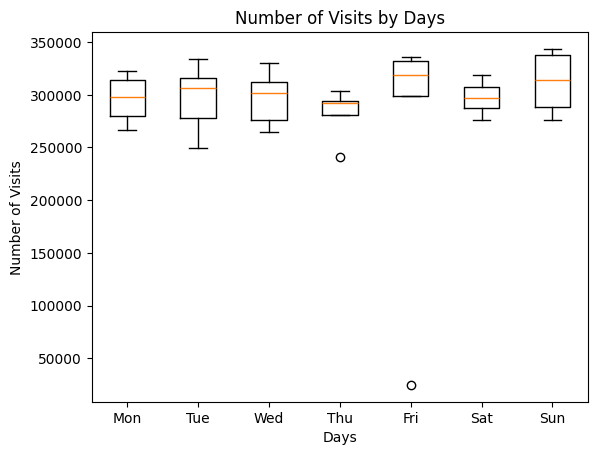

In [7]:
daily_pd = daily.withColumn('day', F.date_format('event_time', 'E')). \
    select('day', 'number_of_daily_visits'). \
    toPandas()
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data_for_plot = [daily_pd[daily_pd['day'] == d]['number_of_daily_visits'] for d in day_order]

plt.boxplot(data_for_plot, tick_labels=day_order)
plt.title('Number of Visits by Days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.show()

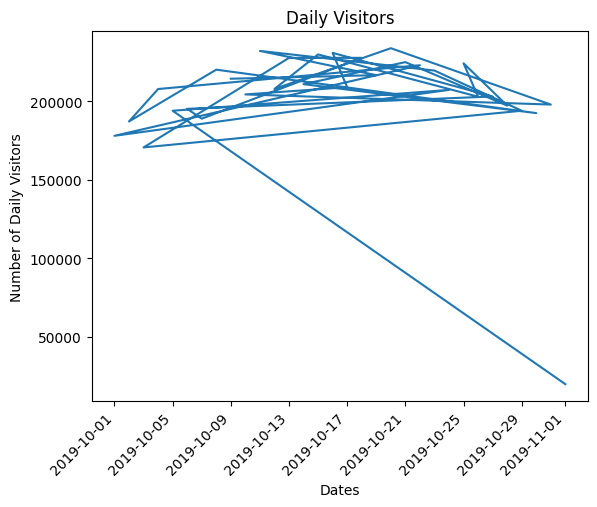

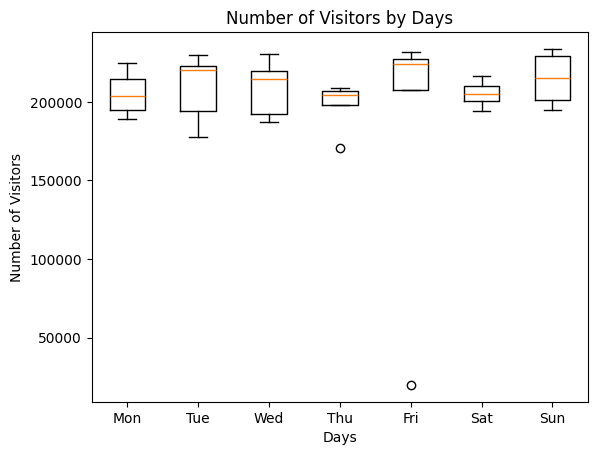

In [ ]:
daily_pd = daily.withColumn('day', F.date_format('event_time', 'E')). \
    select('event_time', 'day', 'number_of_daily_visitors'). \
    orderBy('event_time'). \
    toPandas()

plt.plot(daily_pd['event_time'], daily_pd['number_of_daily_visitors'])
plt.title('Daily Visitors')
plt.ylabel('Number of Daily Visitors')
plt.xlabel('Dates')
plt.xticks(rotation=45, ha='right')
plt.show()

data_for_plot = [daily_pd[daily_pd['day'] == d]['number_of_daily_visitors'] for d in day_order]

plt.boxplot(data_for_plot, tick_labels=day_order)
plt.title('Number of Visitors by Days')
plt.ylabel('Number of Visitors')
plt.xlabel('Days')
plt.show()

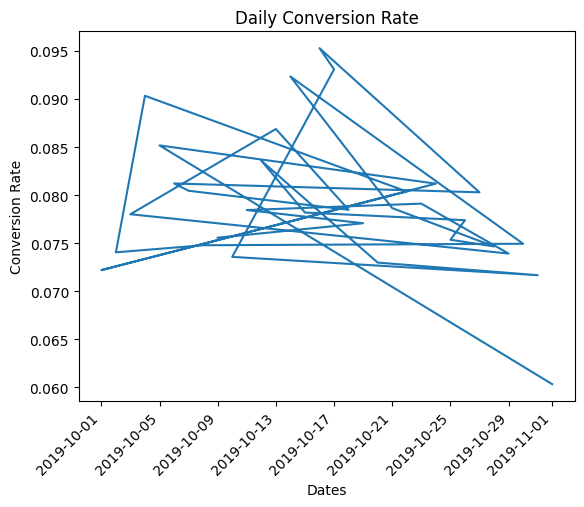

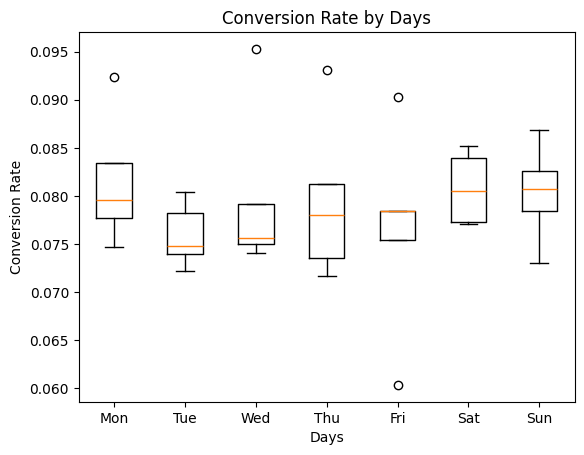

In [ ]:
daily_pd = daily.withColumn('day', F.date_format('event_time', 'E')). \
    select('event_time', 'day', 'conversion_rate'). \
    orderBy('event_time'). \
    toPandas()

plt.plot(daily_pd['event_time'], daily_pd['conversion_rate'])
plt.title('Daily Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xlabel('Dates')
plt.xticks(rotation=45, ha='right')
plt.show()

data_for_plot = [daily_pd[daily_pd['day'] == d]['conversion_rate'] for d in day_order]

plt.boxplot(data_for_plot, tick_labels=day_order)
plt.title('Conversion Rate by Days')
plt.ylabel('Conversion Rate')
plt.xlabel('Days')
plt.show()

In [10]:
customer_table = dataset.where(dataset.event_type == eve_dict['purchase']). \
    groupBy('user_id'). \
    agg(F.count('user_id').alias('number_of_purchases'),
        F.sum('price').alias('total_sales'))
customer_table.show()

+---------+-------------------+------------------+
|  user_id|number_of_purchases|       total_sales|
+---------+-------------------+------------------+
|546839974|                 10|           1322.32|
|555468492|                  1|            167.21|
|518619616|                  4| 611.0799999999999|
|537163771|                  4|           1911.41|
|540805815|                  6|           1287.01|
|555483609|                  2|            305.51|
|553923283|                  4|             686.2|
|542465551|                  1|             72.07|
|552269114|                  2|            410.85|
|518685353|                  1|             15.44|
|551388041|                 34|           8218.79|
|514264972|                 16|15343.460000000001|
|543399383|                  1|            388.81|
|524340312|                  4|             336.5|
|525960487|                  1|             38.07|
|544378707|                  1|            185.71|
|554107795|                  1|

In [11]:
customers_who_purchased = customer_table.select(customer_table.user_id). \
    dropDuplicates(). \
    count()

repeat_customers = customer_table.where('number_of_purchases > 1'). \
    select(customer_table.user_id). \
    dropDuplicates(). \
    count()
    
print(f'There are {customers_who_purchased} customers, who purchased in October, out of these {repeat_customers} are repeat customers.\n')

print('Distribution of Customer by Number of Purchases:')
customer_table.groupBy(customer_table.number_of_purchases).count().show(10)

There are 347118 customers, who purchased in October, out of these 131427 are repeat customers.

Distribution of Customer by Number of Purchases:
+-------------------+-----+
|number_of_purchases|count|
+-------------------+-----+
|                 26|  112|
|                 29|   57|
|                 65|    4|
|                 19|  245|
|                 54|    6|
|                 22|  137|
|                  7| 3143|
|                 77|    3|
|                 34|   41|
|                126|    3|
+-------------------+-----+
only showing top 10 rows



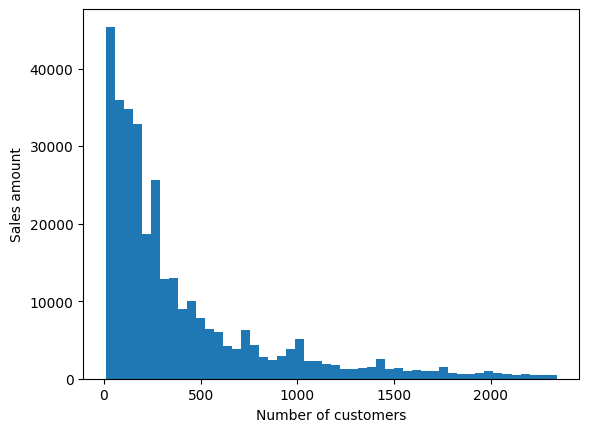

In [12]:
sales_thresholds = customer_table.approxQuantile("total_sales", [0.01, 0.95], 0.0)
customers_filtered = customer_table.filter((customer_table.total_sales >= sales_thresholds[0]) &
                                           (customer_table.total_sales <= sales_thresholds[1]))

plt.hist(customers_filtered.select(customers_filtered.total_sales).toPandas(), 50)
plt.ylabel('Sales amount')
plt.xlabel('Number of customers')
plt.show()

In [13]:
top10p_sales = customer_table.approxQuantile("total_sales", [0.9], 0.0)[0]
top10p_customers = customer_table.filter(F.col("total_sales") >= top10p_sales)
regular_customers = customer_table.filter(F.col("total_sales") < top10p_sales)

print(r'Top 10% customers Purchase Amount-Descriptive Statistics')
top10p_customers.select(top10p_customers.total_sales).summary().show()
print(r'Total sales of top 10% customers:')
top10p_customers.agg(F.sum(top10p_customers.total_sales)).show()

Top 10% customers Purchase Amount-Descriptive Statistics
+-------+------------------+
|summary|       total_sales|
+-------+------------------+
|  count|             34712|
|   mean|3735.4383034685743|
| stddev| 5625.447274491181|
|    min|           1418.31|
|    25%|           1741.34|
|    50%|           2338.77|
|    75%|           3770.35|
|    max|         265569.52|
+-------+------------------+

Total sales of top 10% customers:
+--------------------+
|    sum(total_sales)|
+--------------------+
|1.2966453439000088E8|
+--------------------+



In [14]:
print(r'Bottom 90% customers Purchase Amount-Descriptive Statistics')
regular_customers.select(regular_customers.total_sales).summary().show()
print(r'Total sales of bottom 90% customers:')
regular_customers.agg(F.sum(regular_customers.total_sales)).show()

Bottom 90% customers Purchase Amount-Descriptive Statistics
+-------+------------------+
|summary|       total_sales|
+-------+------------------+
|  count|            312406|
|   mean|321.03406426253196|
| stddev| 314.9402064914853|
|    min|              0.88|
|    25%|             94.21|
|    50%|            205.01|
|    75%|442.46000000000004|
|    max|           1418.25|
+-------+------------------+

Total sales of bottom 90% customers:
+--------------------+
|    sum(total_sales)|
+--------------------+
|1.0029296788000196E8|
+--------------------+



In [15]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [16]:
k_mod = Pipeline(stages=[
    VectorAssembler(inputCols=['number_of_purchases', 'total_sales'], outputCol='features'),
    KMeans(k=3, predictionCol='cluster')
])

k_mod = k_mod.fit(regular_customers)
regular_customers = k_mod.transform(regular_customers)

+-------+-------------------+----------------+----------------+------------------+------------------------+
|cluster|   sum(total_sales)|max(total_sales)|min(total_sales)|  avg(total_sales)|stddev_samp(total_sales)|
+-------+-------------------+----------------+----------------+------------------+------------------------+
|      1|2.775539440000097E7|          317.55|            0.88|135.75041646491948|       84.72508747288632|
|      2|3.584226873000042E7|         1418.25|          769.72| 1040.051904416471|       179.0562318518513|
|      0|3.669530475000034E7|          769.66|          317.56|499.35775668504243|      129.99787143941063|
+-------+-------------------+----------------+----------------+------------------+------------------------+



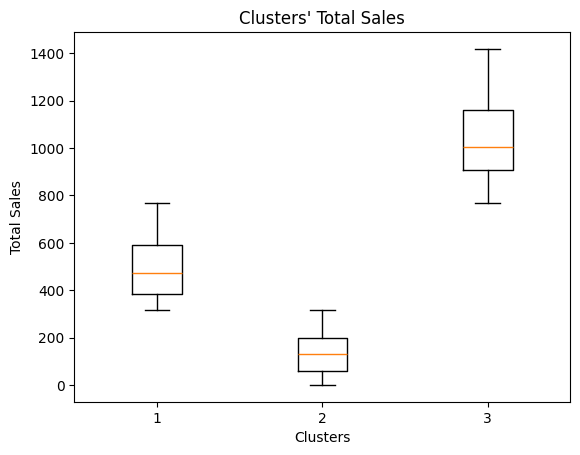

In [17]:
customer_table_joined = customer_table.join(regular_customers.select('user_id', 'cluster'), 'user_id')

customer_table_joined.groupBy(customer_table_joined.cluster).agg(F.sum('total_sales'),
                                                                 F.max('total_sales'),
                                                                 F.min('total_sales'),
                                                                 F.avg('total_sales'),
                                                                 F.stddev('total_sales')).show()

customer_plt = customer_table_joined.select('cluster', 'total_sales'). \
    withColumn('cluster', F.col('cluster') + 1). \
    toPandas()
customer_data = [group["total_sales"].values for _, group in customer_plt.groupby("cluster")]

plt.boxplot(customer_data, tick_labels=sorted(customer_plt["cluster"].unique()))
plt.xlabel('Clusters')
plt.ylabel('Total Sales')
plt.title("Clusters' Total Sales")
plt.show()

In [18]:
shopper_list = dataset.where(f'event_type == {eve_dict["purchase"]}').select('user_id').distinct()
dataset_shoppers = shopper_list.join(dataset, 'user_id')

def extract_cat(txt: float | int):
    for k, v in zip(cat_dict.keys(), cat_dict.values()):
        if v == int(txt):
            return k.split('.')[0]
extract_cat_udf = F.udf(extract_cat)

def extract_subcat(txt: float | int):
    for k, v in zip(cat_dict.keys(), cat_dict.values()):
        if v == int(txt):
            return k.split('.')[1]
extract_subcat_udf = F.udf(extract_subcat)

In [19]:
dataset_shoppers = dataset_shoppers.withColumn('category_lvl_1', extract_cat_udf(dataset_shoppers.category_code)).where('category_lvl_1 != "null"')

shopper_visit_table: ps.DataFrame = dataset_shoppers.groupBy('user_id', 'category_lvl_1'). \
    count(). \
    withColumnRenamed('count', 'visits')
shopper_visit_freq: ps.DataFrame = dataset_shoppers.groupBy('user_id'). \
    count(). \
    withColumnRenamed('count', 'frequency')

shopper_visit_table = shopper_visit_table.join(shopper_visit_freq, 'user_id', 'left')
shopper_visit_table = shopper_visit_table.withColumn('ratio', F.col('visits') / F.col('frequency'))

shopper_visit_table.show()

+---------+--------------+------+---------+-------------------+
|  user_id|category_lvl_1|visits|frequency|              ratio|
+---------+--------------+------+---------+-------------------+
|512574839|   electronics|    14|       27| 0.5185185185185185|
|512599826|   electronics|    33|       34| 0.9705882352941176|
|512706118|    appliances|    82|       92| 0.8913043478260869|
|513023837|          auto|     1|       32|            0.03125|
|513100956|    appliances|     9|      139|0.06474820143884892|
|513106775|   electronics|    11|       46| 0.2391304347826087|
|513171515|   electronics|    86|       99| 0.8686868686868687|
|514373846|       apparel|     5|       61|0.08196721311475409|
|514924323|   electronics|    92|       96| 0.9583333333333334|
|515835821|   electronics|    36|       45|                0.8|
|516235768|  construction|    15|       31| 0.4838709677419355|
|516417030|   electronics|    14|       14|                1.0|
|516806515|     computers|    15|       

In [20]:
focused_shoppers = shopper_visit_table.filter(F.col("ratio") == 1)
diversified_shoppers = shopper_visit_table.filter(F.col("ratio") != 1)


focused_shoppers = focused_shoppers.withColumn(
    "shoppers_interest_groups",
    F.dense_rank().over(ps.Window.orderBy("category_lvl_1"))
)

diversified_pivot = diversified_shoppers. \
    groupBy("user_id"). \
    pivot("category_lvl_1"). \
    agg(F.first("ratio")). \
    fillna(0)

inp_cols = [
    "accessories",
    "apparel",
    "appliances",
    "auto",
    "computers",
    "construction",
    "country_yard",
    "electronics",
    "furniture",
    "kids",
    "medicine",
    "sport",
    "stationery"
]
c_mod = Pipeline(stages=[
    VectorAssembler(outputCol='features', inputCols=inp_cols),
    KMeans(k=4, predictionCol='cluster')
])

if diversified_pivot.count() > 0:
    c_mod = c_mod.fit(diversified_pivot)
    diversified_clustered = c_mod.transform(diversified_pivot)

    cluster_profile = diversified_clustered.groupBy('cluster'). \
        agg(*[F.mean(c).alias(f'mean_{c}') for c in inp_cols]). \
        orderBy('cluster')

    cluster_counts = diversified_clustered.groupBy('cluster'). \
        count(). \
        orderBy('cluster')

    cluster_profile.show()
    cluster_counts.show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|cluster|    mean_accessories|        mean_apparel|     mean_appliances|           mean_auto|      mean_computers|   mean_construction|   mean_country_yard|   mean_electronics|      mean_furniture|           mean_kids|       mean_medicine|          mean_sport|     mean_stationery|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      0|0.013953342841009655|0.040492497474553885| 0.06567457577339396| 0.06819646192868746|0.019799766905879285|  0.5996858245963992|0.00245528948192182

In [21]:
del focused_shoppers
del diversified_shoppers
del diversified_pivot
del shopper_list
del customer_table
del daily
del data_for_plot

In [22]:
dataset = dataset.withColumn('category', extract_cat_udf(dataset.category_code)). \
    withColumn('subcategory', extract_subcat_udf(dataset.category_code))

In [23]:
print(f'Total number of activity: {dataset.count()}')
print(f'Total number of visits: {dataset.select("user_session").distinct().count():.0f}')
print(f'Total number of visitors: {dataset.select("user_id").distinct().count():.0f}')
print(f'Total number of categories: {dataset.select("category").distinct().count():.0f}')
print(f'Total number of subcategories: {dataset.select("subcategory").distinct().count():.0f}')
print(f'Total number of brands: {dataset.select("brand").distinct().count():.0f}')
print(f'Total number of products: {dataset.select("product_id").distinct().count():.0f}')

Total number of activity: 42448764
Total number of visits: 9244422
Total number of visitors: 3022290
Total number of categories: 14
Total number of subcategories: 58
Total number of brands: 3446
Total number of products: 166794


In [24]:
category_summary_table = dataset.groupBy('category'). \
    agg(
        F.count('category').alias('number_of_views'),
        F.count_distinct('user_id').alias('number_of_users'),
        F.count_distinct('user_session').alias('number_of_sessions')
    )

category_sales_table = dataset.where(f'event_type == {eve_dict["purchase"]}').groupBy('category'). \
    agg(
        F.count('category').alias('number_of_purchase'),
        F.sum('price').alias('amount_of_purchase'),
        F.avg('price').alias('average_purchase_amount'),
        F.count_distinct('user_session').alias('number_of_sessions_with_purchase'),
        F.count_distinct('user_id').alias('number_of_shoppers')
    )

category_summary_table = category_summary_table.join(category_sales_table, 'category', 'left')

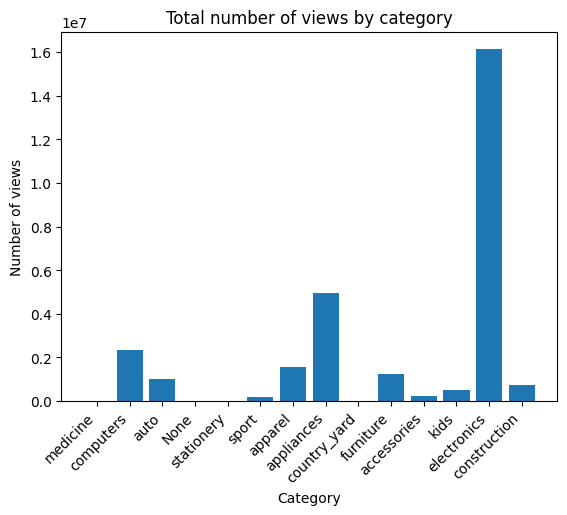

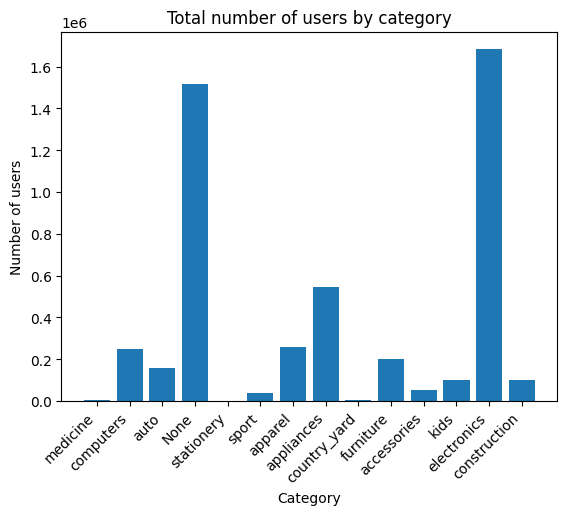

In [25]:
category_pd = category_summary_table.select('category', 'number_of_views').toPandas()
category_pd['category'] = category_pd['category'].astype(str)

plt.bar(category_pd['category'], category_pd['number_of_views'])
plt.title('Total number of views by category')
plt.xlabel('Category')
plt.ylabel('Number of views')
plt.xticks(rotation=45, ha='right')
plt.show()

users_category_pd = category_summary_table.select('category', 'number_of_users').toPandas()
users_category_pd['category'] = users_category_pd['category'].astype(str)

plt.bar(users_category_pd['category'], users_category_pd['number_of_users'])
plt.title('Total number of users by category')
plt.xlabel('Category')
plt.ylabel('Number of users')
plt.xticks(rotation=45, ha='right')
plt.show()

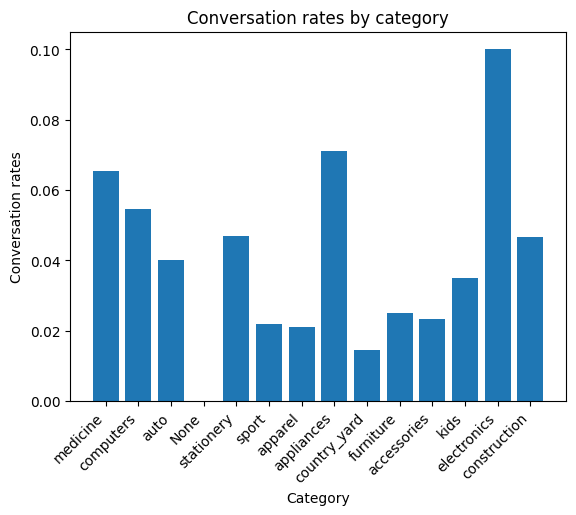

In [26]:
category_summary_table = category_summary_table.withColumn('conversion_rate', F.col('number_of_purchase') / F.col('number_of_sessions'))
category_summary_plt = category_summary_table.select('category', 'conversion_rate').toPandas()
category_summary_plt['category'] = category_summary_plt['category'].astype(str)

plt.bar(category_summary_plt['category'], category_summary_plt['conversion_rate'])
plt.title('Conversation rates by category')
plt.xlabel('Category')
plt.ylabel('Conversation rates')
plt.xticks(rotation=45, ha='right')
plt.show()
del category_summary_plt

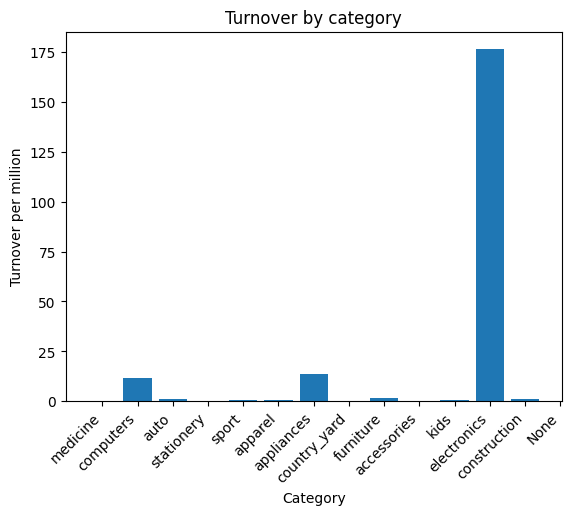

In [27]:
category_turnover_table = category_summary_table.groupBy('category'). \
    agg(F.sum('amount_of_purchase').alias('total_turnover')). \
    withColumn('total_turnover_mil', F.col('total_turnover') / 1000000.0)
category_turnover_plt = category_turnover_table.select('category', 'total_turnover_mil').toPandas()
category_turnover_plt['category'] = category_turnover_plt['category'].astype(str)

plt.bar(category_turnover_plt['category'], category_turnover_plt['total_turnover_mil'])
plt.title('Turnover by category')
plt.xlabel('Category')
plt.ylabel('Turnover per million')
plt.xticks(rotation=45, ha='right')
plt.show()
del category_turnover_plt